### Part 1
Split the training dataset into a real training dataset and a validation datase

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

100%|██████████| 105M/105M [00:00<00:00, 130MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [2]:
%cd /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3

/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


Create Validation Folder and move items

In [3]:
!ls

test  train


In [4]:
import os
import shutil
from pathlib import Path

# Define paths
base_dir = Path('.')  # The current directory
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

# Create validation directory and subfolders if they don't exist
validation_dir.mkdir(exist_ok=True)
(validation_dir / 'REAL').mkdir(exist_ok=True)
(validation_dir / 'FAKE').mkdir(exist_ok=True)

# Function to move a specified number of files
def move_files(source_dir, target_dir, num_files):
    files = list(source_dir.glob('*'))  # Get all files in source_dir
    files_to_move = files[:num_files]  # Select the first num_files

    for file in files_to_move:
        shutil.move(str(file), str(target_dir))

# Move 10,000 images from each subfolder in train to the validation subfolders
move_files(train_dir / 'REAL', validation_dir / 'REAL', 10000)
move_files(train_dir / 'FAKE', validation_dir / 'FAKE', 10000)

print("Files moved successfully!")


Files moved successfully!


### Part 2
Convolutional Neural Network (CNN)

In [5]:
!ls

test  train  validation


Prepare Dataset

In [6]:
import os

print(len(os.listdir("train/REAL")))
print(len(os.listdir("train/FAKE")))
print(len(os.listdir("validation/REAL")))
print(len(os.listdir("validation/FAKE")))

40000
40000
10000
10000


In [7]:
# prompt: Use the image_dataset_from_directory() function to
# load data from the “train”, “validation”, and “test” folders.

import tensorflow as tf

# Define image size and batch size
IMG_WIDTH = 32
IMG_HEIGHT = 32
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 128

# Load datasets using image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    "validation",
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "test",
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 80000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


Building the Model

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_real_or_fake_model():
    model = models.Sequential([
        # Rescale layer (useful for normalizing pixel values between 0 and 1)
        layers.Rescaling(1./255, input_shape=(32, 32, 3)),

        # First convolutional layer followed by max pooling
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer followed by max pooling
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten layer
        layers.Flatten(),

        # First dense layer
        layers.Dense(64, activation='relu'),

        # Output layer for binary classification
        layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary output
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the model
model = create_real_or_fake_model()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,345 (552.13 KB)

 Trainable params: 141,345 (552.13 KB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [9]:
# prompt: train the model with train and validation sets save the best model into drive.

# Define callbacks for saving the best model
checkpoint_filepath = 'CIFAKE/best_model.keras'  # Specify the path on your Google Drive
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the entire model
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model with the highest validation accuracy
    save_best_only=True  # Save only the best model
)

# Train the model
epochs = 30  # Adjust the number of epochs as needed
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    callbacks=[model_checkpoint_callback] # Add the callback to the training process
)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7614 - loss: 0.4636 - val_accuracy: 0.8801 - val_loss: 0.2909
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8877 - loss: 0.2701 - val_accuracy: 0.9092 - val_loss: 0.2262
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9081 - loss: 0.2254 - val_accuracy: 0.9162 - val_loss: 0.2057
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9251 - loss: 0.1940 - val_accuracy: 0.9166 - val_loss: 0.2107
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9279 - loss: 0.1812 - val_accuracy: 0.9257 - val_loss: 0.1906
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9333 - loss: 0.1674 - val_accuracy: 0.9361 - val_loss: 0.1674
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9389 - loss: 0.1581 - val_accuracy: 0.9398 - val_loss: 0.1555
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9430 - loss: 0.1457 - val_accuracy: 0.

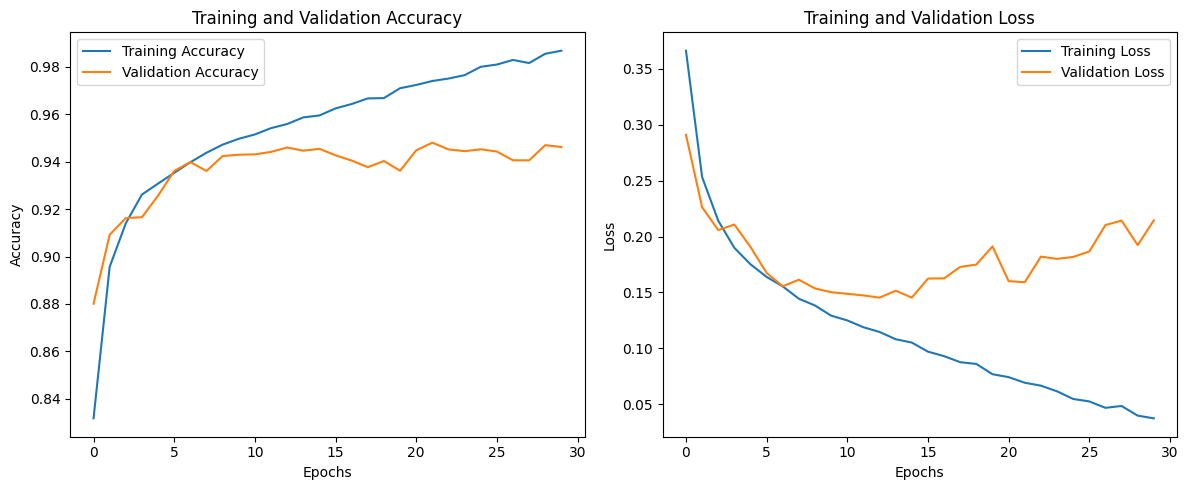

In [13]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable that stores the training history
# For example:
# history = model.fit(...)

def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function with your training history
plot_training_history(history)


In [10]:
# Load the best saved model

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9450 - loss: 0.2040
Test Loss: 0.21671247482299805
Test Accuracy: 0.9430999755859375


Evaluating on loaded Model

In [11]:
loaded_model = tf.keras.models.load_model('CIFAKE/best_model.keras')

In [12]:
# Load the best saved model

# Evaluate the model on the test dataset
loss, accuracy = loaded_model.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9446 - loss: 0.1606
Test Loss: 0.16236554086208344
Test Accuracy: 0.944350004196167
